#Импорты библиотек

In [ ]:
try:
  import numpy as np
  import random
except:
  !pip install numpy
  import numpy as np
  import random

In [ ]:
try:
  from sklearn.cluster import KMeans
  from sklearn.metrics import silhouette_score
  from sklearn.datasets import make_blobs
  from sklearn.metrics import davies_bouldin_score
except:
  !pip install sklearn
  from sklearn.cluster import KMeans
  from sklearn.metrics import silhouette_score
  from sklearn.datasets import make_blobs
  from sklearn.metrics import davies_bouldin_score

In [ ]:
try:
  from skopt import gp_minimize
except:
  !pip install scikit-optimize
  from skopt import gp_minimize

In [ ]:
try:
  import matplotlib.pyplot as plt
except:
  !pip install matplotlib
  import matplotlib.pyplot as plt

In [ ]:
import time
import warnings
warnings.filterwarnings('ignore')

#Класс Bayesian_optimization_stable

In [ ]:
class Silhouette_stable(object):
 
    def __init__(self, data, n_init_points = 3, initial_generator = 'random', 
                 acq_function = 'gp_hedge', noise = 'gaussian', 
                 left_border = 2, right_border = 100, n_calls = 12, 
                 dispersion = 3, random_state = 2022):
        self.data = data
        self.n_init_points = n_init_points
        self.initial_generator = initial_generator
        self.acq_function = acq_function
        self.noise = noise
        self.left_border = left_border
        self.right_border = right_border
        self.n_calls = n_calls
        self.dispersion = dispersion
        self.random_state = random_state

    def score_function(self, n):
      clusterer = KMeans(n_clusters = n[0], random_state = self.random_state)
      preds = clusterer.fit_predict(np.array(self.data))
      return 1 - silhouette_score(self.data, preds)



class DaviesBouldin_stable(object):
 
    def __init__(self, data, n_init_points = 6, initial_generator = 'sobol', 
                 acq_function = 'LCB', kappa = 3, noise = 'gaussian', 
                 left_border = 2, right_border = 100, n_calls = 14, 
                 dispersion = 2, random_state = 2022):
        self.data = data
        self.n_init_points = n_init_points
        self.initial_generator = initial_generator
        self.acq_function = acq_function
        self.kappa = kappa
        self.noise = noise
        self.left_border = left_border
        self.right_border = right_border
        self.n_calls = n_calls
        self.dispersion = dispersion
        self.random_state = random_state

    def score_function(self, n):
      clusterer = KMeans(n_clusters = n[0], random_state = self.random_state)
      preds = clusterer.fit_predict(np.array(self.data))
      return davies_bouldin_score(self.data, preds)



class BayesKMeans_stable(object):
 
    def __init__(self, data):
        self.data = data
        self.x_iters = None
        self.func_vals = None
        self.foundK = None
        if len(data) <= 4000:
          self.methodName = 'silhouette'
          self.method = Silhouette_stable(data)
        else:
          self.methodName = 'daviesBouldin'
          self.method = DaviesBouldin_stable(data)

    def findK(self):
      self.__bayesian_optimization()
      
    def getK(self):
      return self.foundK

    def chooseOptimizationMethod(self, optimized_method):
      if optimized_method == 'silhouette':
          self.method = Silhouette_stable(data)
      elif optimized_method == 'daviesBouldin':
          self.method = DaviesBouldin_stable(data)

    def setOptimizationMethod(self, method):
      self.method = method

    def __bayesian_optimization(self):
      result = gp_minimize(
                  self.method.score_function,
                  [[self.method.left_border, self.method.right_border]],
                  acq_func = self.method.acq_function,
                  n_calls = self.method.n_calls,   
                  n_initial_points = self.method.n_init_points,
                  initial_point_generator = self.method.initial_generator,
                  n_points = self.method.right_border - self.method.left_border + 1,   # Так как поиск происходит только по целым значениям, имеет смысл ограничить число точек
                  noise = self.method.noise
                           )
      x_it = []
      for x in result.x_iters:
        x_it.append(x[0])
      self.x_iters = x_it
      self.func_vals = result.func_vals
      self.foundK = result.x[0]
      self.min_function_value = result.fun

      for d in range(max([self.foundK - self.method.dispersion, 2]), self.foundK + self.method.dispersion + 1):
        if d not in self.x_iters:
          self.x_iters.append(d)
          self.func_vals = np.append(self.func_vals, self.method.score_function([d]))
          if self.func_vals[-1] < self.min_function_value:
            self.min_function_value = self.func_vals[-1]
            self.foundK = d

    def showData(self):
      plt.scatter(self.data[:, 0], self.data[:, 1])
      plt.show()

    def showColoredData(self):
      clusterer = KMeans(n_clusters = self.foundK, random_state = self.method.random_state)
      preds = clusterer.fit_predict(np.array(self.data))
      plt.scatter(self.data[:, 0], self.data[:, 1], c=preds)
      plt.show()  

    def showBayesianPlot(self, line = False):
      d = {}
      for i in range(len(self.x_iters)):
        d[self.x_iters[i]] = self.func_vals[i]
      x_asc = sorted(self.x_iters)
      y_asc = []
      for x in x_asc:
        y_asc.append(d[x])
      if line:
        plt.plot(x_asc, y_asc, label=self.methodName)

      plt.scatter(x_asc, y_asc, label=self.methodName + ' points', marker='x', s=15, c='green')
      plt.scatter(self.foundK, d[self.foundK], c='red', marker='+', s=35, label='Target = ' + str(self.foundK))
      plt.xlabel('n_clusters')  
      plt.ylabel('Score')
      plt.legend()
      plt.show()

# Класс Bayesian Optimization Flexible

In [ ]:
class Silhouette(object):
    def __init__(self, data, random_state = 2022):
        self.data = data
        self.random_state = random_state
        self.function = self.score_function

    def score_function(self, n, predicts = None):
      if predicts is not None:
        preds = predicts
      else:
        clusterer = KMeans(n_clusters = n[0], random_state = self.random_state)
        preds = clusterer.fit_predict(np.array(self.data))
      return 1 - silhouette_score(self.data, preds)



class DaviesBouldin(object):
    def __init__(self, data, random_state = 2022):
        self.data = data
        self.random_state = random_state
        self.function = self.score_function

    def score_function(self, n, predicts = None):
      if predicts is not None:
        preds = predicts
      else:
        clusterer = KMeans(n_clusters = n[0], random_state = self.random_state)
        preds = clusterer.fit_predict(np.array(self.data))
      return davies_bouldin_score(self.data, preds)



class BayesKMeans(object):
    def __init__(self, data):
        self.data = data

        # Определение переменных на будущее
        self.x_iters = None
        self.func_vals = None
        self.foundK = None
        self.border = None
        
        # Определение параметров байесовской оптимизации 2-50, 99%
        self.left_border = 2
        self.right_border = 50
        self.initial_point_generator = 'hammersly'
        self.n_init_points = 4
        self.acq_optimizer = 'lbfgs'
        self.acq_func = 'gp_hedge'
        self.xi = 0.01
        self.kappa = 5
        self.n_restarts_optimizer = 1
        self.noise = 'gaussian'
        self.dispersion = 7
        self.n_calls = 6
        self.x_0 = []
        self.y_0 = []
        self.elbow = []

        # Определение метода
        if len(data) <= 4000:
          self.methodName = 'silhouette'
          self.method = Silhouette(data)
        else:
          self.methodName = 'daviesBouldin'
          self.method = DaviesBouldin(data)

    def __get_elbow(self, n_clusters):
        if n_clusters not in self.x_0:
          model = KMeans(n_clusters=n_clusters)
          predicts = model.fit_predict(self.data)
          self.x_0.append(n_clusters)
          self.y_0.append(self.method.score_function([n_clusters], predicts))
          self.elbow.append(model.inertia_)
          return model.inertia_
        else:
          i = 0
          while self.x_0[i] != n_clusters:
            i += 1
          return self.elbow[i]

    def determineRightBorder(self):
      step = 50
      diff = 20
      level = 0.75
      j = 1
      k_0 = self.__get_elbow((j) * step)
      k_1 = self.__get_elbow((j) * step + diff)
      while (k_1 / k_0 < level):
        j += 1
        k_0 = self.__get_elbow((j) * step)
        k_1 = self.__get_elbow((j) * step + diff)
      self.border = j
      self.right_border = (j) * 50
      print('Right border is {0}'.format(self.right_border))

    def setBayesianParametrs(self, persent = '99'):
      if persent == '95':
        self.initial_point_generator = 'hammersly'
        self.n_init_points = max(4 - self.border, 2)
        self.acq_optimizer = 'lbfgs'
        self.acq_func = 'gp_hedge'
        self.n_restart_optimizer = 1
        self.noise = 'gaussian'
        self.dispersion = 4 + (self.border // 2) * 2
        self.n_calls = 4 + self.border * 2 - 3 * int((self.right_border - 50) / 100)

      elif persent == '99':
        self.initial_point_generator = 'hammersly'
        self.n_init_points = max(4 - self.border, 2)
        self.acq_optimizer = 'lbfgs'
        self.acq_func = 'gp_hedge'
        self.n_restart_optimizer = 1
        self.noise = 'gaussian'
        self.dispersion = 7 + (self.border // 2) * 2
        self.n_calls = 4 + self.border * 2 - 3 * int((self.right_border - 50) / 100)
      else:
        print('Persent value can be "95" or "99"')

    def findK(self):
      self.__bayesian_optimization()
      
    def getK(self):
      return self.foundK

    def chooseOptimizationMethod(self, optimized_method):
      self.x_0 = []
      self.y_0 = []
      self.elbow = []
      if optimized_method == 'silhouette':
          self.method = Silhouette(data)
      elif optimized_method == 'daviesBouldin':
          self.method = DaviesBouldin(data)

    def setOptimizationMethod(self, method):
      self.x_0 = []
      self.y_0 = []
      self.elbow = []
      self.method = method

    def __bayesian_optimization(self):
      x0 = self.x_0[:-1]
      y0 = self.y_0[:-1]
      for i in range(len(x0)):
        x0[i] = [x0[i]]
      result = gp_minimize(
                  self.method.score_function,
                  [[self.left_border, self.right_border]],
                  acq_func = self.acq_func,
                  n_calls = self.n_calls,   
                  n_initial_points = self.n_init_points,
                  initial_point_generator = self.initial_point_generator,
                  acq_optimizer = self.acq_optimizer,
                  n_restarts_optimizer = self.n_restarts_optimizer,
                  kappa = self.kappa,
                  xi = self.xi,
                  x0 = x0,
                  y0 = y0,
                  noise = self.noise
                           )
      x_it = []
      for x in result.x_iters:
        x_it.append(x[0])
      self.x_iters = x_it
      self.func_vals = result.func_vals
      self.foundK = result.x[0]
      self.min_function_value = result.fun

      for d in range(max([self.foundK - self.dispersion, 2]), self.foundK + self.dispersion + 1):
        if d not in self.x_iters:
          self.x_iters.append(d)
          self.func_vals = np.append(self.func_vals, self.method.score_function([d]))
          if self.func_vals[-1] < self.min_function_value:
            self.min_function_value = self.func_vals[-1]
            self.foundK = d

    def showData(self):
      plt.scatter(self.data[:, 0], self.data[:, 1])
      plt.show()

    def showColoredData(self):
      clusterer = KMeans(n_clusters = self.foundK, random_state = self.method.random_state)
      preds = clusterer.fit_predict(np.array(self.data))
      plt.scatter(self.data[:, 0], self.data[:, 1], c=preds)
      plt.show()  

    def showBayesianPlot(self, line = True):
      d = {}
      for i in range(len(self.x_iters)):
        d[self.x_iters[i]] = self.func_vals[i]

      x_asc = sorted(self.x_iters)
      y_asc = []
      for x in x_asc:
        y_asc.append(d[x])

      if line:
        plt.plot(x_asc, y_asc, label=self.methodName)

      plt.scatter(x_asc, y_asc, label=self.methodName + ' points', marker='x', s=15, c='green')
      plt.scatter(self.foundK, d[self.foundK], c='red', marker='+', s=35, label='Target = ' + str(self.foundK))
      plt.xlabel('n_clusters')  
      plt.ylabel('Score')
      plt.legend()
      plt.show()

In [ ]:
class SequentalFind(object):
    def __init__(self, data, level = 1.3):
      self.data = data
      self.level = level
      if len(data) <= 4000:
        self.methodName = 'silhouette'
        self.method = Silhouette(data)
      else:
        self.methodName = 'daviesBouldin'
        self.method = DaviesBouldin(data)
    
    def findNClusters(self):
      st = time.time()
      min_N = 2
      min_func = self.method.score_function([2])
      j = 3
      new_func = self.method.score_function([3])
      while min_func * self.level >= new_func:
        if new_func < min_func:
          min_func = new_func
          min_N = j
        j += 1
        new_func = self.method.score_function([j])
      
      print('Minimum clusters = {0}'.format(min_N))
      print('Minimum value = {0}'.format(min_func))
      print('Time is {0} seconds'.format(round((time.time() - st) * 1000) / 1000))
        

In [ ]:
class RandomSearch(object):
    def __init__(self, data, n_calls = 10, right_bound = 100, dispersion = 2):
      self.data = data
      self.n_calls = n_calls
      self.right_bound = right_bound
      self.dispersion = dispersion
      if len(data) <= 4000:
        self.methodName = 'silhouette'
        self.method = Silhouette(data)
      else:
        self.methodName = 'daviesBouldin'
        self.method = DaviesBouldin(data)
    
    def findNClusters(self):
      st = time.time()
      dictin = {}
      min_N = random.randint(2, self.right_bound)
      min_func = self.method.score_function([min_N])
      dictin[min_N] = min_func
      for i in range(1, self.n_calls):
        j = random.randint(2, self.right_bound)
        if j not in dictin:
          new_func = self.method.score_function([j])
          dictin[j] = new_func
        else:
          new_func = dictin[j]
        if new_func < min_func:
          min_func = new_func
          min_N = j

      for i in range(max(min_N - self.dispersion, 2), min_N + self.dispersion + 1):
        if i not in dictin:
          new_func = self.method.score_function([i])
          dictin[i] = new_func
        else:
          new_func = dictin[i]
        if new_func < min_func:
          min_func = new_func
          min_N = i
      
      print('Minimum clusters = {0}'.format(min_N))
      print('Minimum value = {0}'.format(min_func))
      print('Time is {0} seconds'.format(round((time.time() - st) * 1000) / 1000))
        

In [ ]:
class RandomChoose(object):
    def __init__(self, data, right_bound = 100):
      self.data = data
      self.right_bound = right_bound
      if len(data) <= 4000:
        self.methodName = 'silhouette'
        self.method = Silhouette(data)
      else:
        self.methodName = 'daviesBouldin'
        self.method = DaviesBouldin(data)

    def findNClusters(self):
      st = time.time()
      dictin = {}
      min_N = random.randint(2, self.right_bound)
      min_func = self.method.score_function([min_N])
      
      print('Minimum clusters = {0}'.format(min_N))
      print('Minimum value = {0}'.format(min_func))
      print('Time is {0} seconds'.format(round((time.time() - st) * 1000) / 1000))
        

In [ ]:
a = SequentalFind(new_data)
a.findNClusters()

Minimum clusters = 2
Minimum value = 0.48846661170196326
Time is 0.808 seconds


In [ ]:
a = RandomSearch(new_data, n_calls = 20, dispersion = 6, right_bound = 100)
a.findNClusters()

Minimum clusters = 2
Minimum value = 0.48846661170196326
Time is 6.534 seconds


In [ ]:
a = RandomChoose(new_data, right_bound = 100)
a.findNClusters()

Minimum clusters = 7
Minimum value = 0.6576099008693614
Time is 0.133 seconds


In [ ]:
bayesKMeans = BayesKMeans(new_data)
start = time.time()
bayesKMeans.determineRightBorder()
bayesKMeans.setBayesianParametrs(persent = '99')
bayesKMeans.findK()
print('Time is {0} seconds'.format(round((time.time() - start) * 1000) / 1000))
print('Minimum clusters = {0}'.format(bayesKMeans.getK()))
print('Minimum value = {0}'.format(bayesKMeans.min_function_value))

Right border is 100
Time is 8.451 seconds
Minimum clusters = 2
Minimum value = 0.48846661170196326


In [ ]:
bayesKMeans = BayesKMeans_stable(new_data)
start = time.time()
bayesKMeans.findK()
print('Time is {0} seconds'.format(round((time.time() - start) * 1000) / 1000))
print('Minimum clusters = {0}'.format(bayesKMeans.getK()))
print('Minimum value = {0}'.format(bayesKMeans.min_function_value))

Time is 7.008 seconds
Minimum clusters = 2
Minimum value = 0.48846661170196326


In [ ]:
data = make_blobs(n_samples=10000, n_features=2, centers=216, cluster_std=4, center_box=(-1000, 1000))
data = data[0]

In [ ]:
float('0.0')

0.0

In [ ]:
import csv

adv = []
#with open('AllBooks_baseline_DTM_Labelled.csv') as f:
#with open('online_shoppers_intention.csv') as f:
with open('Wholesale customers data.csv') as f:
  reader = csv.reader(f)
  i = 0
  for row in reader:
    row_arr = []
    j = 0
    if i > 0:
      for elem in row:
          if j >= 0:
            try:
              row_arr.append(float(elem))
            except:
              None
          j += 1
      adv.append(row_arr)
    i += 1

In [ ]:
len(adv)

12330

In [ ]:
len(adv[2])

14

In [ ]:
new_data = []
for i in range(len(adv)):
  if i % 1 == 0:
    new_data.append(adv[i])
new_data = np.array(new_data)

In [ ]:
bayesKMeans = BayesKMeans(data)

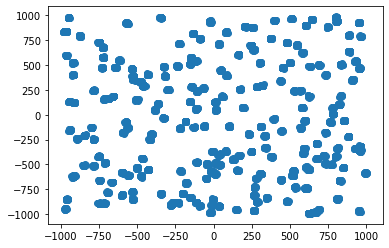

In [ ]:
bayesKMeans.showData()

In [ ]:
start = time.time()
bayesKMeans.determineRightBorder()
print(time.time() - start)

Right border is 100
17.991763830184937


In [ ]:
bayesKMeans.setBayesianParametrs()

In [ ]:
start = time.time()
bayesKMeans.findK()
print(time.time() - start)

85.49921250343323


In [ ]:
bayesKMeans.getK()

7

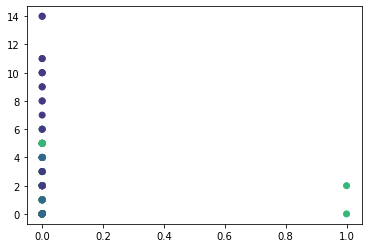

In [ ]:
bayesKMeans.showColoredData()

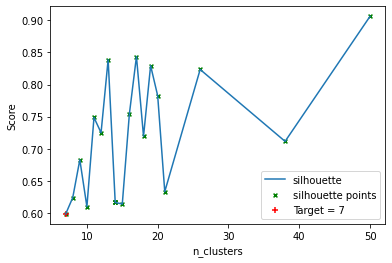

In [ ]:
bayesKMeans.showBayesianPlot(line = True)